In [1]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 42.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompat

Preprocess the data: Tokenize and pad sequences.
Create embeddings: Use word2vec and fastText.
Build models: Define the architectures for the neural network and the CNNs.
Train and evaluate models: Train each model and evaluate its performance

Step 1: Preprocess the Data

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

2025-09-30 16:01:19.525855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759248079.759255      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759248079.835510      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("eftekhar/bangla-textual-emotion-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bangla-textual-emotion-dataset


In [4]:
# Load training data
df = pd.read_excel('/kaggle/input/bangla-textual-emotion-dataset/train_emotion.xlsx')

# Load test data
test_df = pd.read_excel('/kaggle/input/bangla-textual-emotion-dataset/test_emotion.xlsx')

In [5]:
# df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
df.head()

,TEXT,classes
0,এরপর যেই তারা দাফনের কাজ শুরু করবে ঠিক তখনি কব...,fear
1,আমি মন্তব্য করতে দ্বিধা বোধ করছি কারণ আমি পাইথ...,fear
2,আপনারা এসব করে হীনোমোনোত্তর প্রমান দিচ্ছন ....,disgust
3,ঈশ্বর আমি এখানে আঠা আকাশ থেকে সত্যিই উঁচু,surprise
4,আমি প্রাক্তন থেকে দূরে থাকাকে আনন্দিত বোধ করি,joy


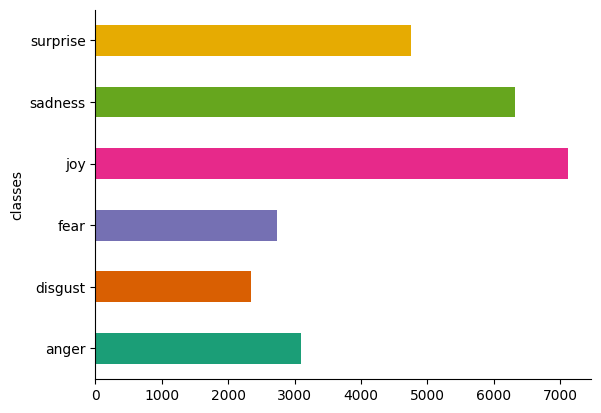

In [7]:
# @title Emotion

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('classes').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

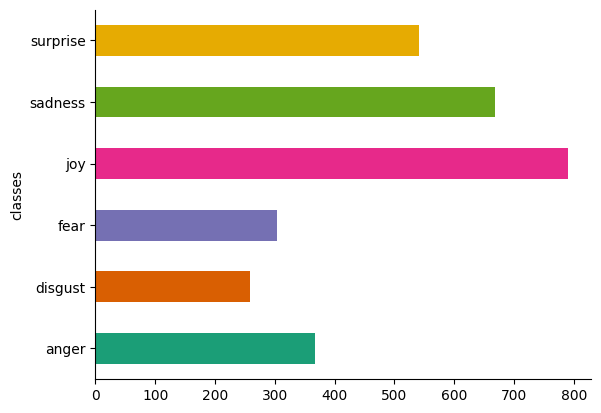

In [8]:
test_df.groupby('classes').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
#label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Emotion_label'] = le.fit_transform(df['classes'])


In [10]:
test_df['Emotion_label'] = le.fit_transform(test_df['classes'])

In [11]:
# #drop Racial biases
# df.drop(['Racial Biases'], axis=1, inplace=True)
# #drop Hatred Percentage
# df.drop(['Hatred Percentage',], axis=1, inplace=True)
# #drop Depression Percentage
# df.drop(['Depression Percentage'], axis=1, inplace=True)
# #drop year
# df.drop(['Year'], axis=1, inplace=True)


In [12]:
#data preprocessing using spacy

#removing unnecessary punctuation
import re

# Data cleaning function
def process_comments(Comment):
    Comment = re.sub('[^\u0980-\u09FF]',' ',str(Comment)) #removing unnecessary punctuation
    return Comment

df['Cleaned'] = df['TEXT'].apply(process_comments)
df.head()


,TEXT,classes,Emotion_label,Cleaned
0,এরপর যেই তারা দাফনের কাজ শুরু করবে ঠিক তখনি কব...,fear,2,এরপর যেই তারা দাফনের কাজ শুরু করবে ঠিক তখনি কব...
1,আমি মন্তব্য করতে দ্বিধা বোধ করছি কারণ আমি পাইথ...,fear,2,আমি মন্তব্য করতে দ্বিধা বোধ করছি কারণ আমি পাইথ...
2,আপনারা এসব করে হীনোমোনোত্তর প্রমান দিচ্ছন ....,disgust,1,আপনারা এসব করে হীনোমোনোত্তর প্রমান দিচ্ছন ...
3,ঈশ্বর আমি এখানে আঠা আকাশ থেকে সত্যিই উঁচু,surprise,5,ঈশ্বর আমি এখানে আঠা আকাশ থেকে সত্যিই উঁচু
4,আমি প্রাক্তন থেকে দূরে থাকাকে আনন্দিত বোধ করি,joy,3,আমি প্রাক্তন থেকে দূরে থাকাকে আনন্দিত বোধ করি


In [13]:
test_df['Cleaned'] = test_df['TEXT'].apply(process_comments)
test_df.head()

,TEXT,classes,Emotion_label,Cleaned
0,আমার মায়ের জন্মদিনের জন্য সবেমাত্র সেরা চমকপ্...,surprise,5,আমার মায়ের জন্মদিনের জন্য সবেমাত্র সেরা চমকপ্...
1,SAC402 নাম্বার ক্লাসের সামনে কয়দিন আগে মন খারা...,sadness,4,নাম্বার ক্লাসের সামনে কয়দিন আগে মন খারা...
2,আমি স্মার্ট বোধ করি কারণ এটি পৃষ্ঠাগুলি খুব জট...,joy,3,আমি স্মার্ট বোধ করি কারণ এটি পৃষ্ঠাগুলি খুব জট...
3,মে‌য়ের জবাব আ‌মি এ বিষ‌য়ের উপর পিএইচ‌ডি কর‌বো...,disgust,1,মে য়ের জবাব আ মি এ বিষ য়ের উপর পিএইচ ডি কর বো...
4,আমি বোঝাতে চাইছি যে এটি আমার কাছে অনুভূত হয়েছ...,anger,0,আমি বোঝাতে চাইছি যে এটি আমার কাছে অনুভূত হয়েছ...


In [14]:
import pandas as pd

# Load Bengali stop words from a CSV file
stop_words_df = pd.read_csv('/kaggle/input/stopwords/stopwords_bangla.csv')  # Assuming the CSV has one column with stop words
stop_words_df=stop_words_df.drop(['Unnamed: 0'], axis=1)
# Convert the stop words to a list
stop_words_list = stop_words_df.iloc[:, 0].tolist()  # Convert the column to a list

# Check the stop words list
print("Stop words list:", stop_words_list[:10])  # Print first 10 stop words for verification


# Function to remove stop words
def remove_stop_words(text, stop_words):
    if isinstance(text, str):  # Ensure the text is a string
        # Tokenize text (simple split for Bengali)
        words = text.split()
        # Filter out stop words
        filtered_words = [word for word in words if word not in stop_words]
        # Join words back into a single string
        return ' '.join(filtered_words)
    else:
        return text  # If text is not a string, return it as is

# Assuming 'df' is the DataFrame and 'Cleaned' is the column with text data
# Check a few entries in the original DataFrame
print("Original texts:", df['Cleaned'].head())

# Apply the function to the DataFrame
df['filtered_text'] = df['Cleaned'].apply(lambda x: remove_stop_words(x, stop_words_list))

test_df['filtered_text'] = test_df['Cleaned'].apply(lambda x: remove_stop_words(x, stop_words_list))


df.head()

Stop words list: ['অই', 'অগত্যা', 'অত: পর', 'অতএব', 'অথচ', 'অথবা', 'অধিক', 'অধীনে', 'অধ্যায়', 'অনুগ্রহ']
Original texts: 0    এরপর যেই তারা দাফনের কাজ শুরু করবে ঠিক তখনি কব...
1    আমি মন্তব্য করতে দ্বিধা বোধ করছি কারণ আমি পাইথ...
2    আপনারা  এসব  করে  হীনোমোনোত্তর প্রমান দিচ্ছন  ...
3          ঈশ্বর  আমি এখানে আঠা আকাশ থেকে সত্যিই উঁচু 
4        আমি প্রাক্তন থেকে দূরে থাকাকে আনন্দিত বোধ করি
Name: Cleaned, dtype: object


,TEXT,classes,Emotion_label,Cleaned,filtered_text
0,এরপর যেই তারা দাফনের কাজ শুরু করবে ঠিক তখনি কব...,fear,2,এরপর যেই তারা দাফনের কাজ শুরু করবে ঠিক তখনি কব...,এরপর যেই দাফনের তখনি কবর স্হানে একটা পাগলের প্...
1,আমি মন্তব্য করতে দ্বিধা বোধ করছি কারণ আমি পাইথ...,fear,2,আমি মন্তব্য করতে দ্বিধা বোধ করছি কারণ আমি পাইথ...,মন্তব্য দ্বিধা বোধ করছি পাইথনে চাই না জড়িতরা ...
2,আপনারা এসব করে হীনোমোনোত্তর প্রমান দিচ্ছন ....,disgust,1,আপনারা এসব করে হীনোমোনোত্তর প্রমান দিচ্ছন ...,আপনারা এসব হীনোমোনোত্তর প্রমান দিচ্ছন জাস্ট ইর...
3,ঈশ্বর আমি এখানে আঠা আকাশ থেকে সত্যিই উঁচু,surprise,5,ঈশ্বর আমি এখানে আঠা আকাশ থেকে সত্যিই উঁচু,ঈশ্বর আঠা আকাশ উঁচু
4,আমি প্রাক্তন থেকে দূরে থাকাকে আনন্দিত বোধ করি,joy,3,আমি প্রাক্তন থেকে দূরে থাকাকে আনন্দিত বোধ করি,থাকাকে আনন্দিত বোধ


In [15]:
x_train = df['filtered_text']
x_test = test_df['filtered_text']


In [16]:
y_train = df['Emotion_label']
y_test = test_df['Emotion_label']

In [17]:
# # Train-test split
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from gensim.models import FastText
import numpy as np

# Train FastText model on the training data
fasttext_model = FastText(sentences=x_train, vector_size=100, window=5, min_count=1, workers=4)

# Precompute zero vectors for out-of-vocabulary words
zero_vector = np.zeros(fasttext_model.vector_size)

# Function to convert text to FastText embeddings
def text_to_embedding(text, model, max_length):
    # Initialize embedding array with zeros
    embedding = np.zeros((max_length, model.vector_size))

    # Iterate through words and fill the embedding array
    for i, word in enumerate(text[:max_length]):
        embedding[i] = model.wv[word] if word in model.wv else zero_vector

    return embedding

# Set the maximum sequence length
max_sequence_length = 100

# Convert texts to embeddings
x_train_emb = np.array([text_to_embedding(text, fasttext_model, max_sequence_length) for text in x_train])
x_test_emb = np.array([text_to_embedding(text, fasttext_model, max_sequence_length) for text in x_test])


In [19]:
x_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 26361 entries, 0 to 26360
Series name: filtered_text
Non-Null Count  Dtype 
--------------  ----- 
26361 non-null  object
dtypes: object(1)
memory usage: 206.1+ KB


In [20]:
y_test.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2929 entries, 0 to 2928
Series name: Emotion_label
Non-Null Count  Dtype
--------------  -----
2929 non-null   int64
dtypes: int64(1)
memory usage: 23.0 KB


## simple RNN

In [22]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding
from tensorflow.keras.layers import Masking

# Define the RNN model
rnn_model = Sequential()
rnn_model.add(Masking(mask_value=0., input_shape=(max_sequence_length, 100)))
rnn_model.add(SimpleRNN(units=128))
rnn_model.add(Dense(units= 6, activation='softmax'))

rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.summary()

# Train the rnn_model
rnn_model.fit(x_train_emb, y_train, epochs=20, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1759248237.759994      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759248237.760777      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,086 (117.52 KB)

 Trainable params: 30,086 (117.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1759248243.580783     130 service.cc:148] XLA service 0x7d1524025e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759248243.581684     130 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759248243.581705     130 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759248243.822363     130 cuda_dnn.cc:529] Loaded cuDNN version 90300


 18/659 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1805 - loss: 1.9460

I0000 00:00:1759248244.871890     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


659/659 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.2717 - loss: 1.7107 - val_accuracy: 0.2917 - val_loss: 1.6578
Epoch 2/20
659/659 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3302 - loss: 1.6188 - val_accuracy: 0.3285 - val_loss: 1.6102
Epoch 3/20
659/659 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3502 - loss: 1.5810 - val_accuracy: 0.3209 - val_loss: 1.6177
Epoch 4/20
659/659 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3489 - loss: 1.5798 - val_accuracy: 0.2727 - val_loss: 1.6735
Epoch 5/20
659/659 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3073 - loss: 1.6496 - val_accuracy: 0.2812 - val_loss: 1.6702
Epoch 6/20
659/659 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3017 - loss: 1.6398 - val_accuracy: 0.2938 - val_loss: 1.6523
Epoch 7/20
659/659 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3129 - loss: 1.6305 - val_accuracy: 0.2998 - val_loss: 1.6432
Epoch 8/20
659/659 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3202 - loss: 1.6209 - val_accuracy: 0.3082 - va

In [25]:
rnn_model.save('rnn_model.h5')

In [23]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = np.argmax(rnn_model.predict(x_test_emb), axis=1)

# Print classification report
print("Results for RNN with Word2Vec:")
print(classification_report(y_test, y_pred))


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Results for RNN with Word2Vec:
              precision    recall  f1-score   support

           0       0.24      0.04      0.07       368
           1       0.27      0.23      0.25       258
           2       0.33      0.10      0.15       304
           3       0.36      0.55      0.43       790
           4       0.31      0.44      0.36       668
           5       0.40      0.29      0.34       541

    accuracy                           0.34      2929
   macro avg       0.32      0.28      0.27      2929
weighted avg       0.33      0.34      0.31      2929



In [24]:
def predict_all_models(sentences, max_length=100):
    # Step 1: Preprocessing
    cleaned = [process_comments(s) for s in sentences]
    filtered = [remove_stop_words(s, stop_words_list) for s in cleaned]

    # Step 2: Convert to embeddings
    x_emb = np.array([text_to_embedding(text, fasttext_model, max_length) for text in filtered])

    # Step 3: Predict with each model
    predictions = {
        "RNN": rnn_model.predict(x_emb),
        #"BiLSTM": bilstm_model.predict(x_emb),
        #"CNN": cnn_model.predict(x_emb),
        #"CNN_BiLSTM": cnn_bilstm_model.predict(x_emb),
        #"BGRU": bgru_model.predict(x_emb),
        #"CNN_BGRU": cnn_bgru_model.predict(x_emb),
    }

    # Step 4: Decode and show results
    for i, text in enumerate(sentences):
        print(f"\n📌 Input: {text}")
        for model_name, probs in predictions.items():
            label_idx = np.argmax(probs[i])
            label = le.inverse_transform([label_idx])[0]
            print(f"→ {model_name} Prediction: {label}")

sample_sentences = [
    "আমি খুব বিষণ্ণ অনুভব করছি",
    "আজকে আমার মনটা খুব ভালো",
    "তুমি আমার সবচেয়ে প্রিয় বন্ধু",
    "সব কিছু ধ্বংস হয়ে যাচ্ছে"
]

predict_all_models(sample_sentences)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step

📌 Input: আমি খুব বিষণ্ণ অনুভব করছি
→ RNN Prediction: sadness

📌 Input: আজকে আমার মনটা খুব ভালো
→ RNN Prediction: sadness

📌 Input: তুমি আমার সবচেয়ে প্রিয় বন্ধু
→ RNN Prediction: disgust

📌 Input: সব কিছু ধ্বংস হয়ে যাচ্ছে
→ RNN Prediction: surprise


In [26]:
sample_sentences = [
    "আমি খুব বিষণ্ণ অনুভব করছি",
    "আজকে আমার মনটা খুব ভালো",
    "তুমি আমার সবচেয়ে প্রিয় বন্ধু",
    "সব কিছু ধ্বংস হয়ে যাচ্ছে"
]

predict_all_models(sample_sentences)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

📌 Input: আমি খুব বিষণ্ণ অনুভব করছি
→ RNN Prediction: sadness

📌 Input: আজকে আমার মনটা খুব ভালো
→ RNN Prediction: sadness

📌 Input: তুমি আমার সবচেয়ে প্রিয় বন্ধু
→ RNN Prediction: disgust

📌 Input: সব কিছু ধ্বংস হয়ে যাচ্ছে
→ RNN Prediction: surprise


## RNN(LSTM)

In [27]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Masking, Bidirectional

# Define the BiLSTM model
bilstm_model = Sequential()
bilstm_model.add(Masking(mask_value=0., input_shape=(max_sequence_length, 100)))
bilstm_model.add(Bidirectional(LSTM(units=128, return_sequences=False, recurrent_regularizer='l2', use_bias=False, kernel_initializer='lecun_uniform', implementation=1)))
bilstm_model.add(Dense(units=6, activation='softmax'))

bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_model.summary()

# Train the bilstm_model
bilstm_model.fit(x_train_emb, y_train, epochs=10, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,014 (918.02 KB)

 Trainable params: 235,014 (918.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.2998 - loss: 2.0632 - val_accuracy: 0.3535 - val_loss: 1.5850
Epoch 2/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.3841 - loss: 1.5421 - val_accuracy: 0.3933 - val_loss: 1.5164
Epoch 3/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.4181 - loss: 1.4815 - val_accuracy: 0.4089 - val_loss: 1.4890
Epoch 4/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.4410 - loss: 1.4487 - val_accuracy: 0.4407 - val_loss: 1.4440
Epoch 5/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.4709 - loss: 1.4053 - val_accuracy: 0.4413 - val_loss: 1.4659
Epoch 6/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.4949 - loss: 1.3550 - val_accuracy: 0.4550 - val_loss: 1.5248
Epoch 7/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.5087 - loss: 1.3533 - val_accuracy: 0.4859 - val_loss: 1.3795
Epoch 8/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.5395 - loss: 1.2633 - 

In [28]:
bilstm_model.save('bilstm_model.h5')

In [29]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = np.argmax(bilstm_model.predict(x_test_emb), axis=1)

# Print classification report
print("Results for RNN with Word2Vec:")
print(classification_report(y_test, y_pred))


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Results for RNN with Word2Vec:
              precision    recall  f1-score   support

           0       0.50      0.16      0.24       368
           1       0.48      0.72      0.58       258
           2       0.49      0.30      0.37       304
           3       0.58      0.66      0.62       790
           4       0.46      0.50      0.48       668
           5       0.58      0.64      0.61       541

    accuracy                           0.53      2929
   macro avg       0.51      0.50      0.48      2929
weighted avg       0.52      0.53      0.51      2929



In [30]:
def predict_all_models(sentences, max_length=100):
    # Step 1: Preprocessing
    cleaned = [process_comments(s) for s in sentences]
    filtered = [remove_stop_words(s, stop_words_list) for s in cleaned]

    # Step 2: Convert to embeddings
    x_emb = np.array([text_to_embedding(text, fasttext_model, max_length) for text in filtered])

    # Step 3: Predict with each model
    predictions = {
        "RNN": rnn_model.predict(x_emb),
        "BiLSTM": bilstm_model.predict(x_emb),
        #"CNN": cnn_model.predict(x_emb),
        #"CNN_BiLSTM": cnn_bilstm_model.predict(x_emb),
        #"BGRU": bgru_model.predict(x_emb),
        #"CNN_BGRU": cnn_bgru_model.predict(x_emb),
    }

    # Step 4: Decode and show results
    for i, text in enumerate(sentences):
        print(f"\n📌 Input: {text}")
        for model_name, probs in predictions.items():
            label_idx = np.argmax(probs[i])
            label = le.inverse_transform([label_idx])[0]
            print(f"→ {model_name} Prediction: {label}")

sample_sentences = [
    "আমি খুব বিষণ্ণ অনুভব করছি",
    "আজকে আমার মনটা খুব ভালো",
    "তুমি আমার সবচেয়ে প্রিয় বন্ধু",
    "সব কিছু ধ্বংস হয়ে যাচ্ছে"
]

predict_all_models(sample_sentences)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step

📌 Input: আমি খুব বিষণ্ণ অনুভব করছি
→ RNN Prediction: sadness
→ BiLSTM Prediction: sadness

📌 Input: আজকে আমার মনটা খুব ভালো
→ RNN Prediction: sadness
→ BiLSTM Prediction: joy

📌 Input: তুমি আমার সবচেয়ে প্রিয় বন্ধু
→ RNN Prediction: disgust
→ BiLSTM Prediction: joy

📌 Input: সব কিছু ধ্বংস হয়ে যাচ্ছে
→ RNN Prediction: surprise
→ BiLSTM Prediction: sadness


#CNN

In [31]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Embedding, Masking

# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Masking(mask_value=0., input_shape=(max_sequence_length, 100)))  # Assuming input_shape remains the same

# Add convolutional layer
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))

# Add max pooling layer
cnn_model.add(MaxPooling1D(pool_size=2))

# Flatten the output from the convolutional layers
cnn_model.add(Flatten())

# Add fully connected (Dense) layer
cnn_model.add(Dense(units=128, activation='relu'))

# Output layer
cnn_model.add(Dense(units=6, activation='softmax'))

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

# Train the cnn_model
cnn_model.fit(x_train_emb, y_train, epochs=10, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 884,230 (3.37 MB)

 Trainable params: 884,230 (3.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3461 - loss: 1.6031 - val_accuracy: 0.4756 - val_loss: 1.3507
Epoch 2/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5317 - loss: 1.2141 - val_accuracy: 0.5115 - val_loss: 1.2622
Epoch 3/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6674 - loss: 0.9063 - val_accuracy: 0.5515 - val_loss: 1.2201
Epoch 4/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7720 - loss: 0.6412 - val_accuracy: 0.5411 - val_loss: 1.3113
Epoch 5/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8581 - loss: 0.4210 - val_accuracy: 0.5471 - val_loss: 1.5593
Epoch 6/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9114 - loss: 0.2740 - val_accuracy: 0.5485 - val_loss: 1.8026
Epoch 7/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9547 - loss: 0.1605 - val_accuracy: 0.5517 - val_loss: 2.0474
Epoch 8/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9611 - loss: 0.1313 - val_accuracy: 0.

In [32]:
cnn_model.save('cnn_model.h5')

In [33]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = np.argmax(cnn_model.predict(x_test_emb), axis=1)

# Print classification report
print("Results for RNN with Word2Vec:")
print(classification_report(y_test, y_pred))


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Results for RNN with Word2Vec:
              precision    recall  f1-score   support

           0       0.38      0.34      0.36       368
           1       0.80      0.81      0.81       258
           2       0.43      0.36      0.39       304
           3       0.51      0.67      0.58       790
           4       0.46      0.43      0.44       668
           5       0.63      0.48      0.54       541

    accuracy                           0.52      2929
   macro avg       0.53      0.51      0.52      2929
weighted avg       0.52      0.52      0.51      2929



In [34]:
def predict_all_models(sentences, max_length=100):
    # Step 1: Preprocessing
    cleaned = [process_comments(s) for s in sentences]
    filtered = [remove_stop_words(s, stop_words_list) for s in cleaned]

    # Step 2: Convert to embeddings
    x_emb = np.array([text_to_embedding(text, fasttext_model, max_length) for text in filtered])

    # Step 3: Predict with each model
    predictions = {
        "RNN": rnn_model.predict(x_emb),
        "BiLSTM": bilstm_model.predict(x_emb),
        "CNN": cnn_model.predict(x_emb),
        #"CNN_BiLSTM": cnn_bilstm_model.predict(x_emb),
        #"BGRU": bgru_model.predict(x_emb),
        #"CNN_BGRU": cnn_bgru_model.predict(x_emb),
    }

    # Step 4: Decode and show results
    for i, text in enumerate(sentences):
        print(f"\n📌 Input: {text}")
        for model_name, probs in predictions.items():
            label_idx = np.argmax(probs[i])
            label = le.inverse_transform([label_idx])[0]
            print(f"→ {model_name} Prediction: {label}")

sample_sentences = [
    "আমি খুব বিষণ্ণ অনুভব করছি",
    "আজকে আমার মনটা খুব ভালো",
    "তুমি আমার সবচেয়ে প্রিয় বন্ধু",
    "সব কিছু ধ্বংস হয়ে যাচ্ছে"
]

predict_all_models(sample_sentences)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step

📌 Input: আমি খুব বিষণ্ণ অনুভব করছি
→ RNN Prediction: sadness
→ BiLSTM Prediction: sadness
→ CNN Prediction: sadness

📌 Input: আজকে আমার মনটা খুব ভালো
→ RNN Prediction: sadness
→ BiLSTM Prediction: joy
→ CNN Prediction: joy

📌 Input: তুমি আমার সবচেয়ে প্রিয় বন্ধু
→ RNN Prediction: disgust
→ BiLSTM Prediction: joy
→ CNN Prediction: sadness

📌 Input: সব কিছু ধ্বংস হয়ে যাচ্ছে
→ RNN Prediction: surprise
→ BiLSTM Prediction: sadness
→ CNN Prediction: sadness


#CNN+BiLSTM

In [35]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Embedding, Masking, Bidirectional, LSTM

# Define the CNN-BiLSTM model
cnn_bilstm_model = Sequential()

# Masking layer to handle padding
cnn_bilstm_model.add(Masking(mask_value=0., input_shape=(max_sequence_length, 100)))

# Convolutional layers
cnn_bilstm_model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
cnn_bilstm_model.add(MaxPooling1D(pool_size=2))

cnn_bilstm_model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
cnn_bilstm_model.add(MaxPooling1D(pool_size=2))

# Bidirectional LSTM layer
cnn_bilstm_model.add(Bidirectional(LSTM(units=128, return_sequences=False, recurrent_regularizer='l2', use_bias=False, kernel_initializer='lecun_uniform', implementation=1)))

# Output layer
cnn_bilstm_model.add(Dense(units=6, activation='softmax'))

cnn_bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_bilstm_model.summary()

# Train the cnn_bilstm_model
cnn_bilstm_model.fit(x_train_emb, y_train, epochs=10, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,862 (1.56 MB)

 Trainable params: 409,862 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.3404 - loss: 2.0020 - val_accuracy: 0.4756 - val_loss: 1.4245
Epoch 2/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5290 - loss: 1.2624 - val_accuracy: 0.5845 - val_loss: 1.1323
Epoch 3/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6470 - loss: 0.9748 - val_accuracy: 0.6463 - val_loss: 0.9772
Epoch 4/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7055 - loss: 0.8205 - val_accuracy: 0.6672 - val_loss: 0.9288
Epoch 5/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7588 - loss: 0.6833 - val_accuracy: 0.6729 - val_loss: 0.9383
Epoch 6/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7985 - loss: 0.5704 - val_accuracy: 0.6873 - val_loss: 0.9295
Epoch 7/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8469 - loss: 0.4472 - val_accuracy: 0.6751 - val_loss: 1.0231
Epoch 8/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8867 - loss: 0.3488 - val_accuracy: 

In [36]:
cnn_bilstm_model.save('cnn_bilstm_model.h5')

In [37]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = np.argmax(cnn_bilstm_model.predict(x_test_emb), axis=1)

# Print classification report
print("Results for RNN with Word2Vec:")
print(classification_report(y_test, y_pred))


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Results for RNN with Word2Vec:
              precision    recall  f1-score   support

           0       0.48      0.62      0.54       368
           1       0.74      0.84      0.79       258
           2       0.62      0.62      0.62       304
           3       0.71      0.76      0.73       790
           4       0.68      0.58      0.63       668
           5       0.77      0.62      0.69       541

    accuracy                           0.67      2929
   macro avg       0.67      0.67      0.67      2929
weighted avg       0.68      0.67      0.67      2929



In [38]:
def predict_all_models(sentences, max_length=100):
    # Step 1: Preprocessing
    cleaned = [process_comments(s) for s in sentences]
    filtered = [remove_stop_words(s, stop_words_list) for s in cleaned]

    # Step 2: Convert to embeddings
    x_emb = np.array([text_to_embedding(text, fasttext_model, max_length) for text in filtered])

    # Step 3: Predict with each model
    predictions = {
        "RNN": rnn_model.predict(x_emb),
        "BiLSTM": bilstm_model.predict(x_emb),
        "CNN": cnn_model.predict(x_emb),
        "CNN_BiLSTM": cnn_bilstm_model.predict(x_emb),
        #"BGRU": bgru_model.predict(x_emb),
        #"CNN_BGRU": cnn_bgru_model.predict(x_emb),
    }

    # Step 4: Decode and show results
    for i, text in enumerate(sentences):
        print(f"\n📌 Input: {text}")
        for model_name, probs in predictions.items():
            label_idx = np.argmax(probs[i])
            label = le.inverse_transform([label_idx])[0]
            print(f"→ {model_name} Prediction: {label}")

sample_sentences = [
    "আমি খুব বিষণ্ণ অনুভব করছি",
    "আজকে আমার মনটা খুব ভালো",
    "তুমি আমার সবচেয়ে প্রিয় বন্ধু",
    "সব কিছু ধ্বংস হয়ে যাচ্ছে"
]

predict_all_models(sample_sentences)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step

📌 Input: আমি খুব বিষণ্ণ অনুভব করছি
→ RNN Prediction: sadness
→ BiLSTM Prediction: sadness
→ CNN Prediction: sadness
→ CNN_BiLSTM Prediction: sadness

📌 Input: আজকে আমার মনটা খুব ভালো
→ RNN Prediction: sadness
→ BiLSTM Prediction: joy
→ CNN Prediction: joy
→ CNN_BiLSTM Prediction: joy

📌 Input: তুমি আমার সবচেয়ে প্রিয় বন্ধু
→ RNN Prediction: disgust
→ BiLSTM Prediction: joy
→ CNN Prediction: sadness
→ CNN_BiLSTM Prediction: joy

📌 Input: সব কিছু ধ্বংস হয়ে যাচ্ছে
→ RNN Prediction: surprise
→ BiLSTM Prediction: sadness
→ CNN Prediction: sadness
→ CNN_BiLSTM Prediction: sadness


## BGRU

In [39]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding, Masking, Bidirectional

# Define the BGRU model
bgru_model = Sequential()
bgru_model.add(Masking(mask_value=0., input_shape=(max_sequence_length, 100)))
bgru_model.add(Bidirectional(GRU(units=128, return_sequences=False, recurrent_regularizer='l2', use_bias=False, kernel_initializer='lecun_uniform', implementation=1)))
bgru_model.add(Dense(units=6, activation='softmax'))

bgru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bgru_model.summary()

# Train the bgru_model
bgru_model.fit(x_train_emb, y_train, epochs=80, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_4 (Masking)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       175,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,646 (690.02 KB)

 Trainable params: 176,646 (690.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
659/659 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.3020 - loss: 2.1415 - val_accuracy: 0.3453 - val_loss: 1.6168
Epoch 2/80
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.3545 - loss: 1.5988 - val_accuracy: 0.3721 - val_loss: 1.5782
Epoch 3/80
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.3903 - loss: 1.5448 - val_accuracy: 0.3745 - val_loss: 1.5447
Epoch 4/80
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.3995 - loss: 1.5188 - val_accuracy: 0.4051 - val_loss: 1.5098
Epoch 5/80
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.4177 - loss: 1.4903 - val_accuracy: 0.4184 - val_loss: 1.4994
Epoch 6/80
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.4433 - loss: 1.4565 - val_accuracy: 0.4271 - val_loss: 1.4846
Epoch 7/80
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.4588 - loss: 1.4279 - val_accuracy: 0.4496 - val_loss: 1.4588
Epoch 8/80
659/659 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.4815 - loss: 1.3894 - 

In [40]:
bgru_model.save('bgru_model.h5')

In [41]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = np.argmax(bgru_model.predict(x_test_emb), axis=1)

# Print classification report
print("Results for RNN with Word2Vec:")
print(classification_report(y_test, y_pred))


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Results for RNN with Word2Vec:
              precision    recall  f1-score   support

           0       0.37      0.39      0.38       368
           1       0.66      0.70      0.68       258
           2       0.49      0.48      0.48       304
           3       0.69      0.68      0.68       790
           4       0.51      0.55      0.53       668
           5       0.65      0.57      0.61       541

    accuracy                           0.57      2929
   macro avg       0.56      0.56      0.56      2929
weighted avg       0.58      0.57      0.57      2929



In [42]:
def predict_all_models(sentences, max_length=100):
    # Step 1: Preprocessing
    cleaned = [process_comments(s) for s in sentences]
    filtered = [remove_stop_words(s, stop_words_list) for s in cleaned]

    # Step 2: Convert to embeddings
    x_emb = np.array([text_to_embedding(text, fasttext_model, max_length) for text in filtered])

    # Step 3: Predict with each model
    predictions = {
        "RNN": rnn_model.predict(x_emb),
        "BiLSTM": bilstm_model.predict(x_emb),
        "CNN": cnn_model.predict(x_emb),
        "CNN_BiLSTM": cnn_bilstm_model.predict(x_emb),
        "BGRU": bgru_model.predict(x_emb),
        #"CNN_BGRU": cnn_bgru_model.predict(x_emb),
    }

    # Step 4: Decode and show results
    for i, text in enumerate(sentences):
        print(f"\n📌 Input: {text}")
        for model_name, probs in predictions.items():
            label_idx = np.argmax(probs[i])
            label = le.inverse_transform([label_idx])[0]
            print(f"→ {model_name} Prediction: {label}")

sample_sentences = [
    "আমি খুব বিষণ্ণ অনুভব করছি",
    "আজকে আমার মনটা খুব ভালো",
    "তুমি আমার সবচেয়ে প্রিয় বন্ধু",
    "সব কিছু ধ্বংস হয়ে যাচ্ছে"
]

predict_all_models(sample_sentences)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step

📌 Input: আমি খুব বিষণ্ণ অনুভব করছি
→ RNN Prediction: sadness
→ BiLSTM Prediction: sadness
→ CNN Prediction: sadness
→ CNN_BiLSTM Prediction: sadness
→ BGRU Prediction: sadness

📌 Input: আজকে আমার মনটা খুব ভালো
→ RNN Prediction: sadness
→ BiLSTM Prediction: joy
→ CNN Prediction: joy
→ CNN_BiLSTM Prediction: joy
→ BGRU Prediction: surprise

📌 Input: তুমি আমার সবচেয়ে প্রিয় বন্ধু
→ RNN Prediction: disgust
→ BiLSTM Prediction: joy
→ CNN Prediction: sadness
→ CNN_BiLSTM Prediction: joy
→ BGRU Prediction: joy

📌 Input: সব কিছু ধ্বংস হয়ে যাচ্ছে
→ RNN Prediction: surprise
→ BiLSTM Prediction: sadness
→ CNN Prediction: sadness
→ CNN_BiLSTM Prediction: sadness
→ BGRU Prediction: sadness


##CNN+BGRU

In [43]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Masking, Bidirectional, Dropout

# Define the CNN + BGRU model
cnn_bgru_model = Sequential()
cnn_bgru_model.add(Masking(mask_value=0., input_shape=(max_sequence_length, 100)))

# CNN Layer
cnn_bgru_model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
cnn_bgru_model.add(MaxPooling1D(pool_size=2))

# BGRU Layer
cnn_bgru_model.add(Bidirectional(GRU(units=128, return_sequences=False, recurrent_regularizer='l2', use_bias=False, kernel_initializer='lecun_uniform', implementation=1)))

# Fully Connected Layer
cnn_bgru_model.add(Dense(units=64, activation='relu'))
cnn_bgru_model.add(Dropout(0.5))

# Output Layer
cnn_bgru_model.add(Dense(units=6, activation='softmax'))

cnn_bgru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_bgru_model.summary()

# Train the model
cnn_bgru_model.fit(x_train_emb, y_train, epochs=40, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_5 (Masking)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 100, 64)        │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,558 (717.02 KB)

 Trainable params: 183,558 (717.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
659/659 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.2953 - loss: 2.1792 - val_accuracy: 0.4112 - val_loss: 1.5082
Epoch 2/40
659/659 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4023 - loss: 1.5130 - val_accuracy: 0.4641 - val_loss: 1.4083
Epoch 3/40
659/659 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4731 - loss: 1.3671 - val_accuracy: 0.5259 - val_loss: 1.2529
Epoch 4/40
659/659 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5286 - loss: 1.2516 - val_accuracy: 0.5714 - val_loss: 1.1601
Epoch 5/40
659/659 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5752 - loss: 1.1462 - val_accuracy: 0.5907 - val_loss: 1.1039
Epoch 6/40
659/659 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6040 - loss: 1.0792 - val_accuracy: 0.6129 - val_loss: 1.0845
Epoch 7/40
659/659 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6338 - loss: 1.0102 - val_accuracy: 0.6291 - val_loss: 1.0440
Epoch 8/40
659/659 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6499 - loss: 0.9691 - val_acc

In [44]:
cnn_bgru_model.save('cnn_bgru_model.h5')

In [45]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = np.argmax(cnn_bgru_model.predict(x_test_emb), axis=1)

# Print classification report
print("Results for RNN with Word2Vec:")
print(classification_report(y_test, y_pred))


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Results for RNN with Word2Vec:
              precision    recall  f1-score   support

           0       0.53      0.45      0.49       368
           1       0.74      0.86      0.79       258
           2       0.61      0.61      0.61       304
           3       0.69      0.70      0.70       790
           4       0.58      0.60      0.59       668
           5       0.72      0.67      0.69       541

    accuracy                           0.65      2929
   macro avg       0.64      0.65      0.65      2929
weighted avg       0.64      0.65      0.64      2929



In [46]:
def predict_all_models(sentences, max_length=100):
    # Step 1: Preprocessing
    cleaned = [process_comments(s) for s in sentences]
    filtered = [remove_stop_words(s, stop_words_list) for s in cleaned]

    # Step 2: Convert to embeddings
    x_emb = np.array([text_to_embedding(text, fasttext_model, max_length) for text in filtered])

    # Step 3: Predict with each model
    predictions = {
        "RNN": rnn_model.predict(x_emb),
        "BiLSTM": bilstm_model.predict(x_emb),
        "CNN": cnn_model.predict(x_emb),
        "CNN_BiLSTM": cnn_bilstm_model.predict(x_emb),
        "BGRU": bgru_model.predict(x_emb),
        "CNN_BGRU": cnn_bgru_model.predict(x_emb),
    }

    # Step 4: Decode and show results
    for i, text in enumerate(sentences):
        print(f"\n📌 Input: {text}")
        for model_name, probs in predictions.items():
            label_idx = np.argmax(probs[i])
            label = le.inverse_transform([label_idx])[0]
            print(f"→ {model_name} Prediction: {label}")

sample_sentences = [
    "আমি খুব বিষণ্ণ অনুভব করছি",
    "আজকে আমার মনটা খুব ভালো",
    "তুমি আমার সবচেয়ে প্রিয় বন্ধু",
    "সব কিছু ধ্বংস হয়ে যাচ্ছে"
]

predict_all_models(sample_sentences)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step

📌 Input: আমি খুব বিষণ্ণ অনুভব করছি
→ RNN Prediction: sadness
→ BiLSTM Prediction: sadness
→ CNN Prediction: sadness
→ CNN_BiLSTM Prediction: sadness
→ BGRU Prediction: sadness
→ CNN_BGRU Prediction: sadness

📌 Input: আজকে আমার মনটা খুব ভালো
→ RNN Prediction: sadness
→ BiLSTM Prediction: joy
→ CNN Prediction: joy
→ CNN_BiLSTM Prediction: joy
→ BGRU Prediction: surprise
→ CNN_BGRU Prediction: joy

📌 Input: তুমি আমার সবচেয়ে প্রিয় বন্ধু
→ RNN Prediction: disgust
→ BiLSTM Prediction: joy
→ CNN Prediction: sadness
→ CNN_BiLSTM Prediction: joy
→ BGRU Prediction: joy
→ CNN_BGRU Prediction: joy

📌 Input: সব কিছু ধ্বংস হয়ে যাচ্ছে
→ RNN Prediction: surprise
→ BiLSTM Prediction: sadness
→ CNN Prediction: sadness
→ CNN_BiLSTM Prediction: sadness
→ BGRU Prediction: sadne

In [47]:
# Save FastText model
from gensim.models import FastText
fasttext_model.save("fasttext_model.model")

In [48]:
# Save label encoder
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

In [54]:
# Step 1: Install huggingface_hub
!pip install huggingface_hub

# Step 2: Login (one time only)
from huggingface_hub import notebook_login
notebook_login()


In [56]:
from huggingface_hub import create_repo

# Use your Hugging Face username and desired repo name
repo_id = "shakun42/bangla-emotion-models"

# Create the repo
create_repo(repo_id=repo_id, repo_type="model", private=True)



RepoUrl('https://huggingface.co/shakun42/bangla-emotion-models', endpoint='https://huggingface.co', repo_type='model', repo_id='shakun42/bangla-emotion-models')

In [58]:
from huggingface_hub import HfApi

# Initialize API
api = HfApi()

# Your repo
repo_id = "shakun42/bangla-emotion-models"

# Upload each file
api.upload_file(
    path_or_fileobj="rnn_model.h5",
    path_in_repo="rnn_model.h5",
    repo_id=repo_id,
    repo_type="model"
)

api.upload_file(
    path_or_fileobj="cnn_model.h5",
    path_in_repo="cnn_model.h5",
    repo_id=repo_id,
    repo_type="model"
)

api.upload_file(
    path_or_fileobj="cnn_bilstm_model.h5",
    path_in_repo="cnn_bilstm_model.h5",
    repo_id=repo_id,
    repo_type="model"
)

api.upload_file(
    path_or_fileobj="bgru_model.h5",
    path_in_repo="bgru_model.h5",
    repo_id=repo_id,
    repo_type="model"
)

api.upload_file(
    path_or_fileobj="cnn_bgru_model.h5",
    path_in_repo="cnn_bgru_model.h5",
    repo_id=repo_id,
    repo_type="model"
)

# Upload FastText model
api.upload_file(
    path_or_fileobj="fasttext_model.model",
    path_in_repo="fasttext_model.model",
    repo_id=repo_id,
    repo_type="model"
)

# Upload label encoder
api.upload_file(
    path_or_fileobj="label_encoder.pkl",
    path_in_repo="label_encoder.pkl",
    repo_id=repo_id,
    repo_type="model"
)


rnn_model.h5:   0%|          | 0.00/390k [00:00<?, ?B/s]

cnn_model.h5:   0%|          | 0.00/10.6M [00:00<?, ?B/s]

cnn_bilstm_model.h5:   0%|          | 0.00/4.97M [00:00<?, ?B/s]

bgru_model.h5:   0%|          | 0.00/2.16M [00:00<?, ?B/s]

cnn_bgru_model.h5:   0%|          | 0.00/2.25M [00:00<?, ?B/s]

fasttext_model.model:   0%|          | 0.00/69.1k [00:00<?, ?B/s]

label_encoder.pkl:   0%|          | 0.00/294 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shakun42/bangla-emotion-models/commit/bd96c4657c1bcdf0c62ecb1e27fa6f19e732d897', commit_message='Upload label_encoder.pkl with huggingface_hub', commit_description='', oid='bd96c4657c1bcdf0c62ecb1e27fa6f19e732d897', pr_url=None, repo_url=RepoUrl('https://huggingface.co/shakun42/bangla-emotion-models', endpoint='https://huggingface.co', repo_type='model', repo_id='shakun42/bangla-emotion-models'), pr_revision=None, pr_num=None)

In [61]:
!mkdir -p /kaggle/working/fasttext_model/
!mv /kaggle/working/fasttext_model.model /kaggle/working/fasttext_model/
!mv /kaggle/working/fasttext_model.model.wv.vectors_ngrams.npy /kaggle/working/fasttext_model/


In [62]:
from huggingface_hub import HfApi

api = HfApi()
repo_id = "shakun42/bangla-emotion-models"

# Upload the entire folder
api.upload_folder(
    folder_path="/kaggle/working/fasttext_model",
    path_in_repo="fasttext_model",  # optional: to keep it in a folder inside the repo
    repo_id=repo_id,
    repo_type="model"
)


fasttext_model.model.wv.vectors_ngrams.npy:   0%|          | 0.00/800M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shakun42/bangla-emotion-models/commit/1c70e6f219e356c85b8bb7d141e95b7e779a7fc2', commit_message='Upload folder using huggingface_hub', commit_description='', oid='1c70e6f219e356c85b8bb7d141e95b7e779a7fc2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/shakun42/bangla-emotion-models', endpoint='https://huggingface.co', repo_type='model', repo_id='shakun42/bangla-emotion-models'), pr_revision=None, pr_num=None)

# INFERENCE

In [ ]:
# Load stop words
stop_words_df = pd.read_csv("stopwords_bangla.csv").drop(['Unnamed: 0'], axis=1)
stop_words_list = stop_words_df.iloc[:, 0].tolist()

In [ ]:
# Clean Bengali text
def process_comments(comment):
    return re.sub('[^\u0980-\u09FF]', ' ', str(comment))

# Remove Bengali stop words
def remove_stop_words(text, stop_words):
    if isinstance(text, str):
        words = text.split()
        return ' '.join([word for word in words if word not in stop_words])
    return text

# Convert text to FastText embedding
def text_to_embedding(text, model, max_length=100):
    zero_vector = np.zeros(model.vector_size)
    words = text.split()
    embedding = np.zeros((max_length, model.vector_size))
    for i, word in enumerate(words[:max_length]):
        embedding[i] = model.wv[word] if word in model.wv else zero_vector
    return embedding


In [ ]:
def predict_all_models(sentences, max_length=100):
    # Step 1: Preprocessing
    cleaned = [process_comments(s) for s in sentences]
    filtered = [remove_stop_words(s, stop_words_list) for s in cleaned]

    # Step 2: Convert to embeddings
    x_emb = np.array([text_to_embedding(text, fasttext_model, max_length) for text in filtered])

    # Step 3: Predict with each model
    predictions = {
        "RNN": rnn_model.predict(x_emb),
        "BiLSTM": bilstm_model.predict(x_emb),
        "CNN": cnn_model.predict(x_emb),
        "CNN_BiLSTM": cnn_bilstm_model.predict(x_emb),
        "BGRU": bgru_model.predict(x_emb),
        "CNN_BGRU": cnn_bgru_model.predict(x_emb),
    }

    # Step 4: Decode and show results
    for i, text in enumerate(sentences):
        print(f"\n📌 Input: {text}")
        for model_name, probs in predictions.items():
            label_idx = np.argmax(probs[i])
            label = le.inverse_transform([label_idx])[0]
            print(f"→ {model_name} Prediction: {label}")


In [ ]:
sample_sentences = [
    "আমি খুব বিষণ্ণ অনুভব করছি",
    "আজকে আমার মনটা খুব ভালো",
    "তুমি আমার সবচেয়ে প্রিয় বন্ধু",
    "সব কিছু ধ্বংস হয়ে যাচ্ছে"
]

predict_all_models(sample_sentences)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step

📌 Input: আমি খুব বিষণ্ণ অনুভব করছি
→ RNN Prediction: sad
→ BiLSTM Prediction: surprise
→ CNN Prediction: surprise
→ CNN_BiLSTM Prediction: surprise
→ BGRU Prediction: surprise
→ CNN_BGRU Prediction: surprise

📌 Input: আজকে আমার মনটা খুব ভালো
→ RNN Prediction: sad
→ BiLSTM Prediction: surprise
→ CNN Prediction: surprise
→ CNN_BiLSTM Prediction: surprise
→ BGRU Prediction: surprise
→ CNN_BGRU Prediction: surprise

📌 Input: তুমি আমার সবচেয়ে প্রিয় বন্ধু
→ RNN Prediction: sad
→ BiLSTM Prediction: surprise
→ CNN Prediction: surprise
→ CNN_BiLSTM Prediction: surprise
→ BGRU Prediction: surprise
→ CNN_BGRU Prediction: surprise

📌 Input: সব কিছু ধ্বংস হয়ে যাচ্ছে
→ RNN Prediction: sad
→ BiLSTM Prediction: surprise
→ CNN Prediction: surprise
→ CNN_BiLSTM Prediction: surprise
→ BGRU Prediction: surprise
→ CNN_BGRU Prediction: surprise


# PROBLEM CHECK


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming df['Emotion_label'] is numeric label (0-5)
X_train, X_test, y_train, y_test = train_test_split(
    df['Text'], df['Emotion_label'], test_size=0.2, stratify=df['Emotion_label'], random_state=42
)

# Check proportion
train_dist = y_train.value_counts(normalize=True).sort_index()
test_dist = y_test.value_counts(normalize=True).sort_index()
print("Train dist:\n", train_dist)
print("Test dist:\n", test_dist)


Train dist:
 Emotion_label
0    0.166667
1    0.166667
2    0.166667
3    0.166667
4    0.166667
5    0.166667
Name: proportion, dtype: float64
Test dist:
 Emotion_label
0    0.166667
1    0.166667
2    0.166667
3    0.166667
4    0.166667
5    0.166667
Name: proportion, dtype: float64


NameError: name 'x_emb' is not defined

In [ ]:
print(le.classes_)  # Should list all 6 emotion classes


['angry' 'disgust' 'fear' 'happy' 'sad' 'surprise']


In [ ]:
print(df['Emotion'].value_counts())

Emotion
disgust     6000
angry       6000
happy       6000
surprise    6000
fear        6000
sad         6000
Name: count, dtype: int64


In [ ]:
print(x_train_emb[0])  # Should not be all zeros


[[-0.0453263   0.46514672  0.43291408 ...  0.53204703 -0.11840678
  -0.32215399]
 [-0.27795336  0.39239231 -0.07010761 ... -0.25331259 -0.29142129
   0.16153455]
 [-0.04320806  0.24751353  1.07403266 ... -0.3247911   0.28765357
  -0.08243299]
 ...
 [ 0.13195793  0.2316501  -0.00429623 ... -0.18760639 -0.1520184
  -0.35139334]
 [-0.0453263   0.46514672  0.43291408 ...  0.53204703 -0.11840678
  -0.32215399]
 [-0.46622482  0.47197524  0.04399601 ... -0.11274689 -0.29369071
  -0.00621238]]


In [ ]:
print(x_train_emb[0])  # Should not be all zeros


[[-0.0453263   0.46514672  0.43291408 ...  0.53204703 -0.11840678
  -0.32215399]
 [-0.27795336  0.39239231 -0.07010761 ... -0.25331259 -0.29142129
   0.16153455]
 [-0.04320806  0.24751353  1.07403266 ... -0.3247911   0.28765357
  -0.08243299]
 ...
 [ 0.13195793  0.2316501  -0.00429623 ... -0.18760639 -0.1520184
  -0.35139334]
 [-0.0453263   0.46514672  0.43291408 ...  0.53204703 -0.11840678
  -0.32215399]
 [-0.46622482  0.47197524  0.04399601 ... -0.11274689 -0.29369071
  -0.00621238]]


In [ ]:
df['Emotion'].value_counts(normalize=True)


,proportion
Emotion,
disgust,0.166667
angry,0.166667
happy,0.166667
surprise,0.166667
fear,0.166667
sad,0.166667


In [ ]:
print(text_to_embedding("আমি ভালো আছি", fasttext_model).sum())


-0.0854694867929311


In [ ]:
sample_sentences = [
    "আমি খুব বিষণ্ণ অনুভব করছি",
    "আজকে আমার মনটা খুব ভালো",
    "তুমি আমার সবচেয়ে প্রিয় বন্ধু",
    "সব কিছু ধ্বংস হয়ে যাচ্ছে"
]
# Clean and remove stop words
cleaned = [re.sub('[^\u0980-\u09FF]', ' ', str(s)) for s in sample_sentences]
filtered = [' '.join([word for word in sentence.split() if word not in stop_words_list]) for sentence in cleaned]
def text_to_embedding(text, model, max_length=100):
    zero_vector = np.zeros(model.vector_size)
    words = text.split()
    embedding = np.zeros((max_length, model.vector_size))
    for i, word in enumerate(words[:max_length]):
        embedding[i] = model.wv[word] if word in model.wv else zero_vector
    return embedding

x_emb = np.array([text_to_embedding(text, fasttext_model, 100) for text in filtered])


In [ ]:
print(x_emb.shape)  # Should be (4, 100, 100)


(4, 100, 100)


In [ ]:
for i, model in enumerate([rnn_model, bilstm_model, cnn_model, cnn_bilstm_model, bgru_model, cnn_bgru_model]):
    pred_probs = model.predict(x_emb)[0]  # prediction for first input
    print(f"Model {i}: Probabilities: {pred_probs}, Predicted: {np.argmax(pred_probs)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Model 0: Probabilities: [0.04176634 0.07024845 0.00322652 0.07633467 0.7785886  0.02983535], Predicted: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Model 1: Probabilities: [0.15737332 0.15201455 0.16877341 0.17257755 0.1732763  0.17598481], Predicted: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Model 2: Probabilities: [0.01806661 0.02576437 0.343401   0.17349206 0.06446143 0.37481448], Predicted: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Model 3: Probabilities: [0.06675832 0.0895899  0.16607483 0.1559984  0.15292    0.3686586 ], Predicted: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Model 4: Probabilities: [0.0958406  0.09014276 0.24406064 0.15036756 0.14091578 0.2786726 ], Predicted: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Model 5: Probabilities: [0.04969841 0.05034977 0.268261   0.16591713 0.10185803 0.36391568], Predicted: 5


In [ ]:
for model in [rnn_model, cnn_model, bilstm_model, bgru_model]:
    pred = model.predict(x_emb)
    print(np.argmax(pred, axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[4 4 4 4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[5 5 5 5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[5 5 5 5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[5 5 5 5]


In [ ]:
print(le.classes_)  # This will list something like: ['angry', 'happy', 'neutral', 'sad', 'surprise', 'fear']


['angry' 'disgust' 'fear' 'happy' 'sad' 'surprise']


In [ ]:
print(f"Label 4 = {le.classes_[4]}")
print(f"Label 5 = {le.classes_[5]}")


Label 4 = sad
Label 5 = surprise


In [ ]:
print("Full dataset distribution:")
print(df['Emotion'].value_counts(normalize=True))


Full dataset distribution:
Emotion
disgust     0.166667
angry       0.166667
happy       0.166667
surprise    0.166667
fear        0.166667
sad         0.166667
Name: proportion, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print("Train set distribution:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nTest set distribution:")
print(pd.Series(y_test).value_counts(normalize=True))


Train set distribution:
Emotion_label
2    0.169132
5    0.167813
1    0.167083
0    0.165764
4    0.165139
3    0.165069
Name: proportion, dtype: float64

Test set distribution:
Emotion_label
3    0.173056
4    0.172778
0    0.170278
1    0.165000
5    0.162083
2    0.156806
Name: proportion, dtype: float64


In [ ]:
print(df['Emotion'].head(20))  # Check first few rows


0      disgust
1     surprise
2     surprise
3      disgust
4      disgust
5          sad
6        happy
7        angry
8        angry
9        happy
10        fear
11         sad
12        fear
13       angry
14       angry
15        fear
16        fear
17       happy
18       happy
19       angry
Name: Emotion, dtype: object


In [ ]:
print(df['Emotion'].tail(50))  # Check first few rows


35950       happy
35951    surprise
35952       angry
35953     disgust
35954    surprise
35955     disgust
35956    surprise
35957        fear
35958    surprise
35959       angry
35960       happy
35961    surprise
35962         sad
35963    surprise
35964        fear
35965         sad
35966       happy
35967        fear
35968       happy
35969    surprise
35970        fear
35971       angry
35972     disgust
35973    surprise
35974    surprise
35975       happy
35976       happy
35977    surprise
35978     disgust
35979        fear
35980    surprise
35981       angry
35982       angry
35983     disgust
35984       happy
35985       angry
35986         sad
35987     disgust
35988    surprise
35989       happy
35990         sad
35991        fear
35992       angry
35993       angry
35994       happy
35995        fear
35996         sad
35997       happy
35998         sad
35999        fear
Name: Emotion, dtype: object


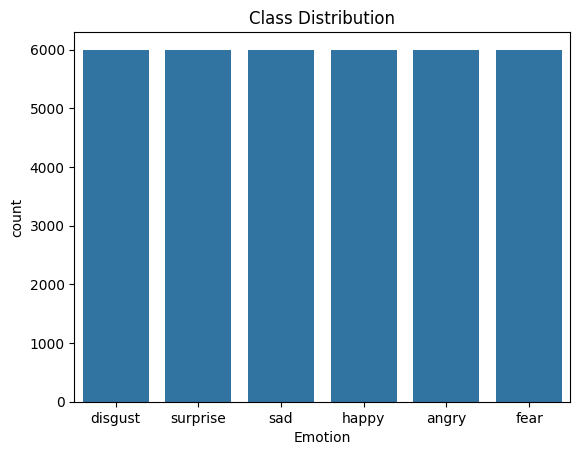

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Emotion')
plt.title("Class Distribution")
plt.show()


In [ ]:
df1 = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
print(df1['Emotion'].head(20))



0      disgust
1     surprise
2     surprise
3      disgust
4      disgust
5          sad
6        happy
7        angry
8        angry
9        happy
10        fear
11         sad
12        fear
13       angry
14       angry
15        fear
16        fear
17       happy
18       happy
19       angry
Name: Emotion, dtype: object


In [ ]:
print(df1['Emotion'].tail(20))

35980    surprise
35981       angry
35982       angry
35983     disgust
35984       happy
35985       angry
35986         sad
35987     disgust
35988    surprise
35989       happy
35990         sad
35991        fear
35992       angry
35993       angry
35994       happy
35995        fear
35996         sad
35997       happy
35998         sad
35999        fear
Name: Emotion, dtype: object


In [ ]:
# # Function to preprocess a new sentence for inference
# def preprocess_sentence(sentence, stop_words, max_length, fasttext_model):
#     # Clean the sentence
#     cleaned_sentence = process_comments(sentence)

#     # Remove stop words
#     filtered_sentence = remove_stop_words(cleaned_sentence, stop_words)

#     # Convert to embedding
#     embedding = text_to_embedding(filtered_sentence.split(), fasttext_model, max_length)

#     # Add batch dimension
#     embedding = np.expand_dims(embedding, axis=0)

#     return embedding

# # Example Bengali sentences
# example_sentences = [
#     "এইটা খুব ভালো খবর", # happy
#     "আমি খুব রেগে আছি", # angry
#     "আমার মন খারাপ লাগছে", # sad
#     "এইটা খুবই আশ্চর্যজনক", # surprise
#     "আমি বিরক্ত বোধ করছি", # disgust
#     "এইটা ঘৃণার যোগ্য" # disgust or angry
# ]

# # Dictionary to map emotion labels back to emotion names
# emotion_map = {
#     0: 'angry',
#     1: 'disgust',
#     2: 'fear',
#     3: 'happy',
#     4: 'sad',
#     5: 'surprise'
# }

# # Perform inference for each model
# models = {
#     "Simple RNN": rnn_model, # This will currently point to the last model assigned to 'model'
#     "BiLSTM": bilstm_model, # This will currently point to the last model assigned to 'model'
#     "CNN": cnn_model, # This will currently point to the last model assigned to 'model'
#     "CNN+BiLSTM": cnn_bilstm_model, # Assuming 'cnn_bilstm_model' was assigned
#     "BGRU": bgru_model, # This will currently point to the last model assigned to 'model'
#     "CNN+BGRU": cnn_bgru_model # Assuming 'cnn_bgru_model' was assigned
# }

# for sentence in example_sentences:
#     preprocessed_sentence = preprocess_sentence(sentence, stop_words_list, max_sequence_length, fasttext_model)
#     print(f"Sentence: {sentence}")

#     for model_name, trained_model in models.items():
#         if trained_model is not None:
#             prediction = trained_model.predict(preprocessed_sentence)
#             predicted_class = np.argmax(prediction, axis=1)[0]
#             predicted_emotion = emotion_map[predicted_class]
#             print(f"  {model_name} Prediction: {predicted_emotion} (Probabilities: {prediction[0]})")
#         else:
#             print(f"  {model_name}: Model not trained or not available.")
#     print("-" * 20)

Sentence: এইটা খুব ভালো খবর
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
  Simple RNN Prediction: surprise (Probabilities: [0.08779913 0.08858287 0.20399287 0.20389725 0.12665464 0.28907323])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
  BiLSTM Prediction: surprise (Probabilities: [0.08779913 0.08858287 0.20399287 0.20389725 0.12665464 0.28907323])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
  CNN Prediction: surprise (Probabilities: [0.08779913 0.08858287 0.20399287 0.20389725 0.12665464 0.28907323])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
  BGRU Prediction: surprise (Probabilities: [0.08779913 0.08858287 0.20399287 0.20389725 0.12665464 0.28907323])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
  CNN+BGRU Prediction: surprise (Probabilities: [0.08071513 0.03063448 0.22009884 0.15748669 0.15042038 0.3606445 ])
--------------------
Sentence: আমি খুব রেগে আছি
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
  Simple RNN Prediction: surprise (Probabilities: [0.09217212 0.08897989 0.20996433 0.2020588  0.13119547 0.27562937])
1

In [ ]:
# # Simpler inference function
# def predict_emotion(sentence, model, stop_words, max_length, fasttext_model, emotion_map):
#     preprocessed_sentence = preprocess_sentence(sentence, stop_words, max_length, fasttext_model)
#     prediction = model.predict(preprocessed_sentence)
#     predicted_class = np.argmax(prediction, axis=1)[0]
#     predicted_emotion = emotion_map[predicted_class]
#     return predicted_emotion

# # Example of how to use the simpler function with one of the trained models
# # Replace 'cnn_bgru_model' with the variable name of the model you want to use
# # For example, if you want to use the Simple RNN model and it was saved as 'rnn_model', use rnn_model instead.
# sentence_to_predict = "এইটা খুব ভালো খবর"
# predicted_emotion = predict_emotion(sentence_to_predict, cnn_bgru_model, stop_words_list, max_sequence_length, fasttext_model, emotion_map)
# print(f"Sentence: {sentence_to_predict}")
# print(f"Predicted Emotion (using CNN+BGRU): {predicted_emotion}")

# # You can easily adapt this to predict using other models as well.
# # For example, using the Simple RNN model (if it was saved as 'rnn_model'):
# # predicted_emotion_rnn = predict_emotion(sentence_to_predict, rnn_model, stop_words_list, max_sequence_length, fasttext_model, emotion_map)
# # print(f"Predicted Emotion (using Simple RNN): {predicted_emotion_rnn}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sentence: এইটা খুব ভালো খবর
Predicted Emotion (using CNN+BGRU): surprise
